In [1]:
import geopandas as gpd
import pandas as pd
import s3fs
import numpy as np
import math
from shapely.geometry import Polygon, box
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

# 1. Read Observation Data into Geopandas Frame

In [2]:
DATASET_PATH = '../data/full_dataset.csv'
RASTER_PATH = '../data/rasters/'

In [3]:

BUCKET_NAME = 'datasets-sdm'
folder = 'geoLifeCLEF/observations'
train_file, test_file = 'observations_us_train.csv', 'observations_us_test.csv'
s3_train_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, train_file)

In [4]:
train_usa = pd.read_csv(s3_train_path,header='infer', sep=';',)
train_usa.head()

,observation_id,latitude,longitude,species_id,subset
0,20000173,33.197660,-116.180680,4911,train
1,20000175,34.037968,-118.876755,4912,train
2,20000176,27.620740,-97.222690,4913,train
3,20000177,29.155582,-95.653930,4914,train
4,20000179,36.605740,-121.959510,4915,train


In [5]:
train_df, val_df = train_usa[train_usa.subset == 'train'], train_usa[train_usa.subset == 'val']
len(train_df), len(val_df)

(931132, 25099)

In [6]:
del train_usa

In [7]:
train_gdf = gpd.GeoDataFrame(train_df, geometry=gpd.points_from_xy(train_df.longitude, train_df.latitude))\
                .drop(['latitude', 'longitude'], axis=1).set_crs(4326)
# train_gdf.to_crs
train_gdf.head()

,observation_id,species_id,subset,geometry
0,20000173,4911,train,POINT (-116.18068 33.19766)
1,20000175,4912,train,POINT (-118.87676 34.03797)
2,20000176,4913,train,POINT (-97.22269 27.62074)
3,20000177,4914,train,POINT (-95.65393 29.15558)
4,20000179,4915,train,POINT (-121.95951 36.60574)


In [8]:
train_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# 2. Create grid for USA (AOI)

## 2.1 Use a generic map outline for the USA

In [9]:
import geopandas as gpd
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<AxesSubplot:>

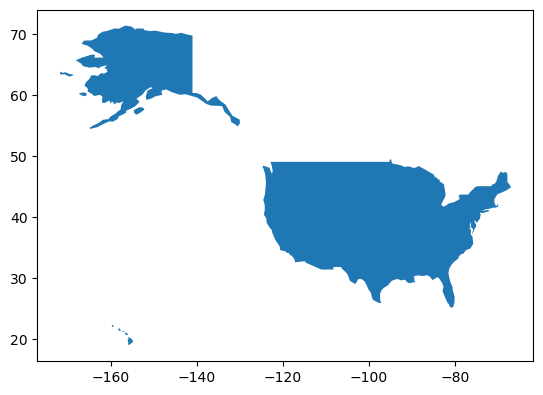

In [10]:
usa = world[world['name'] == 'United States of America']
usa.plot()

## 2.1 Now we only want continental USA, so clip to continental bounds

<AxesSubplot:>

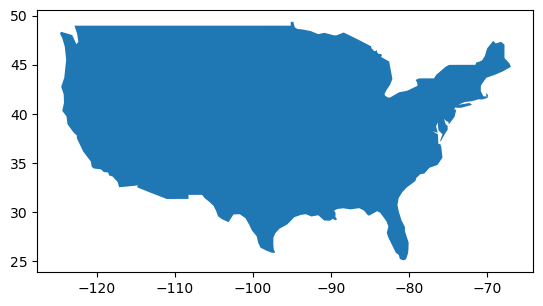

In [11]:
from shapely.geometry import Polygon

continental_bounds = Polygon([(-130,50), (-60,50), (-60,20), (-130,20)])
usa = usa.clip(continental_bounds)
usa.plot()

# 3. Species Level Kernel Function

## 3.1 Extract one species to test with

In [ ]:
species_id_counts = train_df.species_id.value_counts()
species_id_counts.min()

In [ ]:
plt.hist(species_id_counts, bins=50)
plt.show()

## Build a class with all the data and functions needed for gridding and kernels

In [12]:
%load_ext autoreload

In [13]:
#Run this to reload the python file
%autoreload 2
from grid_dask import *


In [15]:
shutdown_all_clusters()

In [16]:
cluster, client = setup_dask_cluster(mem=32)

Setting up new cluster..
Getting client..
<Client: 'tls://10.244.159.116:8786' processes=0 threads=0, memory=0 B>
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.64ecd992f0d0429a91fb8ff1336abdf7/status


In [17]:
grid_res = 0.1
obs_usa = Observations(train_gdf, usa, grid_res_deg=grid_res)

Gridding..
Creating Land Mask..
Num entries before masking:  142680
Num entries after masking:  85149
<Client: 'tls://10.244.159.116:8786' processes=2 threads=2, memory=64.00 GiB> https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.64ecd992f0d0429a91fb8ff1336abdf7/status
(85149, 2)


In [18]:
obs_usa.grid_gd

,geometry,grid_id
0,"POLYGON ((-124.68721 48.18000, -124.68721 48.2...",0
1,"POLYGON ((-124.58721 47.88000, -124.58721 47.9...",1
2,"POLYGON ((-124.58721 47.98000, -124.58721 48.0...",2
3,"POLYGON ((-124.58721 48.08000, -124.58721 48.1...",3
4,"POLYGON ((-124.58721 48.18000, -124.58721 48.2...",4
...,...,...
85144,"POLYGON ((-67.08721 44.98000, -67.08721 45.080...",85144
85145,"POLYGON ((-66.98721 44.68000, -66.98721 44.780...",85145
85146,"POLYGON ((-66.98721 44.78000, -66.98721 44.880...",85146
85147,"POLYGON ((-66.98721 44.88000, -66.98721 44.980...",85147


### Optimized grid testing

In [122]:
unique, counts = np.unique(obs_usa.land_mask, return_counts=True)

#display unique values and counts side by side
print(np.asarray((unique, counts)).T)

[[    0 59733]
 [    1 82947]]


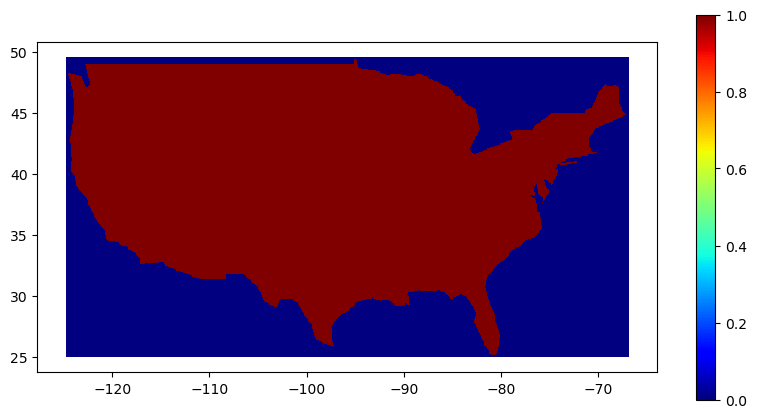

In [117]:
fig, ax = plt.subplots(figsize=(10,10))
obs_usa.grid_gd.plot(ax=ax, column='mask', edgecolor = 'none', legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
# usa.plot(ax=ax,  color='none')
# train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
plt.show()

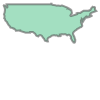

In [109]:
w = usa.simplify(0.1).geometry
w.iloc[0]

In [118]:
series = obs_usa.grid_gd.within(w.iloc[0]).to_numpy()

unique, counts = np.unique(series, return_counts=True)

#display unique values and counts side by side
print(np.asarray((unique, counts)).T)

[[    0 59733]
 [    1 82947]]


In [16]:
obs_usa.grid_gd.loc[5510:5520].geometry.centroid

/tmp/ipykernel_4404/2153824327.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  obs_usa.grid_gd.loc[5510:5520].geometry.centroid


5510    POINT (-122.53721 34.83000)
5511    POINT (-122.53721 34.93000)
5512    POINT (-122.53721 35.03000)
5513    POINT (-122.53721 35.13000)
5514    POINT (-122.53721 35.23000)
5515    POINT (-122.53721 35.33000)
5516    POINT (-122.53721 35.43000)
5517    POINT (-122.53721 35.53000)
5518    POINT (-122.53721 35.63000)
5519    POINT (-122.53721 35.73000)
5520    POINT (-122.53721 35.83000)
dtype: geometry

In [123]:
obs_usa.grid_np[5510:5521]

array([[-119.53721008,   48.63      ],
       [-119.53721008,   48.73      ],
       [-119.53721008,   48.83      ],
       [-119.53721008,   48.93      ],
       [-119.43721008,   34.43      ],
       [-119.43721008,   34.53      ],
       [-119.43721008,   34.63      ],
       [-119.43721008,   34.73      ],
       [-119.43721008,   34.83      ],
       [-119.43721008,   34.93      ],
       [-119.43721008,   35.03      ]])

### Combine chosen_species_grid into the primary observations grid with the following structures:

**Possibility A: Per observation**

| SpeciesID | Probability | GridID | Geometry |
| --- | --- | --- | --- |
| 115 | 0.7 | 7743 | POLYGON ((-112.48721 34.48000, -112.48721 34.5... |


Or

**Possibility B: Per Grid**

| SpeciesID | SpeciesID | ... | SpeciesID | GridID | Geometry |
| --- | --- | --- | --- | --- | --- |
| 115 | 4443 | ... | 19328 | 52  | POLYGON ((-112.48721 34.48000, -112.48721 34.5... |

We pick option A, since it provides a more memory efficient method

### TEST Displays
Let's take species ID: 115, that has 723 observations across the USA

In [51]:
chosen_id = 115
obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=1.0, kernel='gaussian', cumulative=True)

In [52]:
obs_usa.grid_kde

,geometry,grid_id,prob_115
0,"POLYGON ((-124.68721 48.08000, -124.68721 48.5...",0,0.000000
1,"POLYGON ((-124.18721 39.58000, -124.18721 40.0...",1,0.000000
2,"POLYGON ((-124.18721 40.08000, -124.18721 40.5...",2,0.000000
3,"POLYGON ((-124.18721 40.58000, -124.18721 41.0...",3,0.000000
4,"POLYGON ((-124.18721 41.08000, -124.18721 41.5...",4,0.000000
...,...,...,...
3593,"POLYGON ((-67.18721 45.58000, -67.18721 46.080...",3593,0.000000
3594,"POLYGON ((-67.18721 46.08000, -67.18721 46.580...",3594,0.000000
3595,"POLYGON ((-67.18721 46.58000, -67.18721 47.080...",3595,0.000000
3596,"POLYGON ((-66.68721 44.58000, -66.68721 45.080...",3596,0.000033


In [55]:
kernels = obs_usa.grid_kde

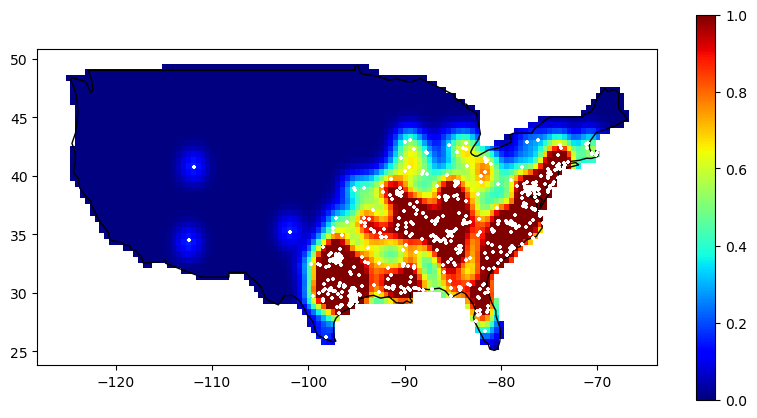

In [56]:
col_name = 'prob_{}'.format(chosen_id)

fig, ax = plt.subplots(figsize=(10,10))
kernels.plot(ax=ax, column=col_name, edgecolor = 'none', alpha = 1, legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
usa.plot(ax=ax,  color='none')
train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
plt.show()

#### Let's do a few more and make it cumulative

In [21]:
chosen_id = 4911
obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=1.3, kernel='epanechnikov', cumulative=True)


In [22]:
chosen_id = 46
obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=2.0, kernel='linear', cumulative=True)

In [23]:
obs_usa.grid_kde

,geometry,grid_id,prob_115,prob_4911,prob_46
0,"POLYGON ((-124.68721 24.98000, -124.68721 25.0...",0,0.0,0.0,0.0
1,"POLYGON ((-124.68721 25.08000, -124.68721 25.1...",1,0.0,0.0,0.0
2,"POLYGON ((-124.68721 25.18000, -124.68721 25.2...",2,0.0,0.0,0.0
3,"POLYGON ((-124.68721 25.28000, -124.68721 25.3...",3,0.0,0.0,0.0
4,"POLYGON ((-124.68721 25.38000, -124.68721 25.4...",4,0.0,0.0,0.0
...,...,...,...,...,...
142675,"POLYGON ((-66.78721 49.08000, -66.78721 49.180...",142675,0.0,0.0,0.0
142676,"POLYGON ((-66.78721 49.18000, -66.78721 49.280...",142676,0.0,0.0,0.0
142677,"POLYGON ((-66.78721 49.28000, -66.78721 49.380...",142677,0.0,0.0,0.0
142678,"POLYGON ((-66.78721 49.38000, -66.78721 49.480...",142678,0.0,0.0,0.0


In [ ]:
kernels = obs_usa.grid_kde.clip(usa).reset_index(drop=True)

col_name = 'prob_{}'.format(chosen_id)

fig, ax = plt.subplots(figsize=(10,10))
kernels.plot(ax=ax, column=col_name, edgecolor = 'none', alpha = 1, legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
usa.plot(ax=ax,  color='none')
train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
ax.set_title('Probability Field of Species {}'.format(chosen_id))
plt.show()

In [ ]:
obs_usa.clear_kde()

## Grid and KDE all species

In [31]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.64ecd992f0d0429a91fb8ff1336abdf7/status,


In [32]:
import dask

In [33]:
@dask.delayed
def kernel_per_species(grid_gd, grid_np, gdf_chosen, 
                       kde:bool=True, chosen_id:int=0, cumulative:bool=False, 
                       radius:float=0.5, kernel:str='gaussian'):

    """
    Inputs:
    kde: whether or not to apply KDE
        if False: only group observations within a cell
        if True: group and then apply KDE
    chosen_id: Species ID for a single chosen species
    grid: grid to which these observations must conform
    radius: radius in degrees for the kernel function
    kernel: 'linerar' / 'epanechnikov' / 'gaussian' ..
    cumulative: keep adding to a master species list -> grid_kde

    Output:

    """

    ##Group observations per cell:



    # Remove duplicate counts
    # With intersect, those that fall on a boundary will be allocated to all cells that share that boundary
    # chosen_species_grid = chosen_species_grid.drop_duplicates(subset = ['speciesID']).reset_index(drop = True)

    chosen_species_grid = gpd.sjoin(gdf_chosen, grid_gd, how='inner', predicate='within').drop(['index_right'], axis=1)
    # display(chosen_species_grid)

    # Add a field with constant value of 1
    chosen_species_grid['num_obs'] = 1.0

    # Group GeoDataFrame by cell while aggregating the Count values
    chosen_species_grid = chosen_species_grid.groupby('grid_id').agg({'num_obs':'sum'})

    chosen_species_grid = grid_gd.merge(chosen_species_grid, on = 'grid_id', how = "right")

    if (kde and radius*2 > grid_res):

        #List of grids that have observations for this species
        chosen_grids = list(chosen_species_grid['grid_id'])
        # print(chosen_grids, chosen_species_grid)
        #sanity check
        if len(chosen_grids) == 0:
            return 

        # Create training set for KDE
        x_train = grid_np[chosen_grids,:]
        y_train = chosen_species_grid['num_obs'].to_numpy()


        tree = KDTree(x_train)
        y_hat = tree.kernel_density(grid_np, h=radius, kernel=kernel)*(1*(radius**2))

        # y_hat /= y_hat.max()
        # print("Max y_hat = ", y_hat.max())
        #Cap all cells at 1
        y_hat[y_hat > 1.0] = 1.0
        y_hat[y_hat < 1e-5] = 0.0

        return y_hat


                   
def kde(obs, classes, radius:float=1.0, kernel:str='gaussian'):
    """Populates the grid_kde data structure
       with 1 column per species_id for every grid_cell
       **fingers crossed**
    """
    y_hats = []
    
    grid_gd = obs.grid_gd
    grid_np = obs.grid_np
    gdf_obs = obs.gdf_obs
    
    print("Building Parallel Compute Graph")

    for id in classes:
        # gdf_chosen = dask.delayed(gdf[gdf.species_id==id])
        gdf_chosen = gdf_obs[gdf_obs.species_id==id]
        y_hats.append(kernel_per_species(grid_gd=grid_gd, grid_np=grid_np, gdf_chosen=gdf_chosen, 
                                         kde=True, chosen_id=id, radius=radius, kernel=kernel, cumulative=True))
    print("Ready for parallel compute...")
    return y_hats   



In [34]:
# obs_usa.class_list
classes = obs_usa.class_list


In [29]:
prob_kde = kde(obs_usa,classes)

Building Parallel Compute Graph


In [30]:
prob_kde = dask.compute(prob_kde)


KeyboardInterrupt



In [ ]:
prob_kde[0][1].max(), len(prob_kde[0][99])

## Assign the prob_kdes to a new column in a new geopandas frame

In [20]:
import dask_geopandas as dgpd
kde_dgpd = dgpd.from_geopandas(obs_usa.grid_gd, npartitions=int(len(classes))+1)

for i, chosen_id in enumerate(classes):
    col_name = 'prob_{}'.format(chosen_id)
    kde_dgpd.assign(col_name=prob_kde[0][i])
    # kde_dgpd[col_name] = prob_kde[0][i]
    
kde_dgpd.compute()

NameError: name 'classes' is not defined

In [ ]:
%%time
kde_gdf = obs_usa.grid_gd.copy()

for i, chosen_id in enumerate(classes):
    col_name = 'prob_{}'.format(chosen_id)
    kde_gdf[col_name] = prob_kde[0][i]

In [88]:
kde_gdf.head(10)

,geometry,grid_id,prob_4911,prob_4912,prob_4913,prob_4914,prob_4915,prob_4916,prob_2950,prob_4917,...,prob_5734,prob_5735,prob_2410,prob_5737,prob_5738,prob_484,prob_4405,prob_5741,prob_5743,prob_5744
0,"POLYGON ((-124.68721 48.08000, -124.68721 48.5...",0,0.0,0.000000,0.0,0.0,0.124161,0.0,0.260517,0.0,...,0.019035,0.0,0.000000,0.0,0.0,0.0,0.006171,0.000175,0.0,0.029419
1,"POLYGON ((-124.18721 39.58000, -124.18721 40.0...",1,0.0,0.105903,0.0,0.0,0.503243,0.0,0.281570,0.0,...,0.006545,0.0,0.018047,0.0,0.0,0.0,0.000000,0.102103,0.0,0.323317
2,"POLYGON ((-124.18721 40.08000, -124.18721 40.5...",2,0.0,0.132144,0.0,0.0,0.547013,0.0,0.381106,0.0,...,0.012626,0.0,0.012411,0.0,0.0,0.0,0.000000,0.086065,0.0,0.269256
3,"POLYGON ((-124.18721 40.58000, -124.18721 41.0...",3,0.0,0.143013,0.0,0.0,0.563240,0.0,0.451166,0.0,...,0.020655,0.0,0.007175,0.0,0.0,0.0,0.000000,0.065577,0.0,0.215994
4,"POLYGON ((-124.18721 41.08000, -124.18721 41.5...",4,0.0,0.124579,0.0,0.0,0.525689,0.0,0.442812,0.0,...,0.027844,0.0,0.003394,0.0,0.0,0.0,0.000000,0.044597,0.0,0.166320
5,"POLYGON ((-124.18721 41.58000, -124.18721 42.0...",5,0.0,0.085311,0.0,0.0,0.428907,0.0,0.362098,0.0,...,0.030341,0.0,0.001292,0.0,0.0,0.0,0.000000,0.029317,0.0,0.129798
6,"POLYGON ((-124.18721 42.08000, -124.18721 42.5...",6,0.0,0.045617,0.0,0.0,0.300744,0.0,0.261303,0.0,...,0.026807,0.0,0.000392,0.0,0.0,0.0,0.000000,0.026970,0.0,0.119769
7,"POLYGON ((-124.18721 46.08000, -124.18721 46.5...",7,0.0,0.000000,0.0,0.0,0.097276,0.0,0.453787,0.0,...,0.073850,0.0,0.000000,0.0,0.0,0.0,0.000946,0.043117,0.0,0.043552
8,"POLYGON ((-124.18721 46.58000, -124.18721 47.0...",8,0.0,0.000000,0.0,0.0,0.115541,0.0,0.451795,0.0,...,0.069989,0.0,0.000000,0.0,0.0,0.0,0.002915,0.018535,0.0,0.045654
9,"POLYGON ((-124.18721 47.08000, -124.18721 47.5...",9,0.0,0.000000,0.0,0.0,0.146625,0.0,0.452430,0.0,...,0.069790,0.0,0.000000,0.0,0.0,0.0,0.006993,0.006606,0.0,0.060754


In [18]:
obs_usa.grid_kde.columns


Index(['geometry', 'grid_id', 'mask', 'prob_4911', 'prob_4912', 'prob_4913',
       'prob_4914', 'prob_4915', 'prob_4916', 'prob_2950',
       ...
       'prob_2309', 'prob_2897', 'prob_1460', 'prob_3932', 'prob_1436',
       'prob_1948', 'prob_4678', 'prob_1232', 'prob_2985', 'prob_272'],
      dtype='object', length=14127)

In [42]:
obs_usa.save_kde('geolifeclef_usa_0.5deg_kde')


In [45]:
obs_usa.clear_kde()
obs_usa.load_kde('geolifeclef_usa_0.5deg_kde.feather')

In [46]:
obs_usa.grid_kde

,geometry,grid_id,prob_4911,prob_4912,prob_4914,prob_4915,prob_4916,prob_2950,prob_4917,prob_4918,...,prob_1647,prob_17036,prob_16086,prob_371,prob_2309,prob_2897,prob_1460,prob_1436,prob_1948,prob_2985
0,"POLYGON ((-123.68721 40.08000, -123.68721 40.5...",0,0.0,0.140454,0.0,0.236986,0.0,0.292686,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((-123.68721 40.58000, -123.68721 41.0...",1,0.0,0.159155,0.0,0.299609,0.0,0.353801,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((-123.68721 41.08000, -123.68721 41.5...",2,0.0,0.140454,0.0,0.299609,0.0,0.372506,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000020,0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((-123.68721 41.58000, -123.68721 42.0...",3,0.0,0.096532,0.0,0.236986,0.0,0.341149,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000078,0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((-123.68721 46.58000, -123.68721 47.0...",4,0.0,0.000000,0.0,0.000000,0.0,0.262126,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000078,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3191,"POLYGON ((-68.18721 46.58000, -68.18721 47.080...",3191,0.0,0.000000,0.0,0.000000,0.0,0.060930,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3192,"POLYGON ((-67.68721 44.58000, -67.68721 45.080...",3192,0.0,0.000000,0.0,0.000000,0.0,0.230591,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3193,"POLYGON ((-67.68721 45.08000, -67.68721 45.580...",3193,0.0,0.000000,0.0,0.000000,0.0,0.195186,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3194,"POLYGON ((-67.68721 45.58000, -67.68721 46.080...",3194,0.0,0.000000,0.0,0.000000,0.0,0.134383,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


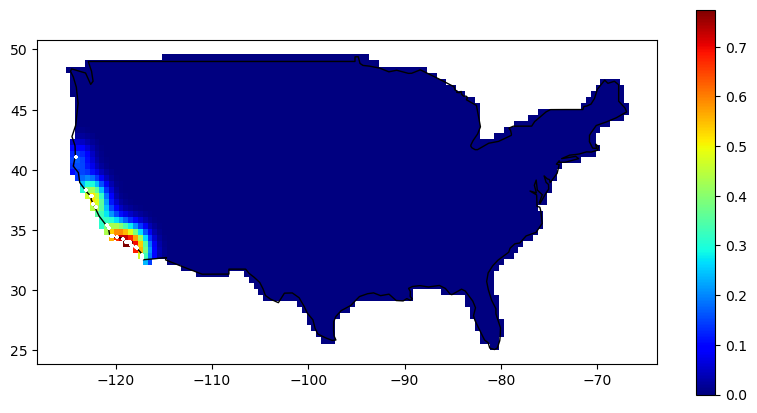

In [87]:
chosen_id = 4912
col_name = 'prob_{}'.format(chosen_id)

fig, ax = plt.subplots(figsize=(10,10))
kde_gdf.plot(ax=ax, column=col_name, edgecolor = 'none', legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
usa.plot(ax=ax,  color='none')
train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
plt.show()

In [ ]:
## Save to disk as feather


## Test Dask Clusters

In [35]:
import time, random

In [36]:
@dask.delayed
def inc(x,n):
    time.sleep(random.random())
    return x ** n
@dask.delayed
def dec(x,n):
    time.sleep(random.random())
    return x ** (1/n)
@dask.delayed
def add(x, y):
    time.sleep(random.random())
    return x + y

In [37]:
%%time

def compound(w,n):
    zs = []
    for i in range(1,n):
        x = inc(w,i)
        y = dec(w,i)
        z = add(x, y)
        zs.append(z)
        
    return zs

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [38]:
%%time
#zs = dask.persist(*zs)  # trigger computation in the background

x = np.random.rand(30,30) # some large array
# x = dask.delayed(x) #need to delay array also
zs = dask.compute(compound(x,100))


KeyboardInterrupt

